# Sentiment Analysis Using Dictionary-Based Approach

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package punkt to /Users/glenmond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Pickle Functions

In [24]:
def pickle_dump(df, filename='no-filename.pickle'):
    
    if filename:
        with open(filename, "wb") as output_file:
            pickle.dump(df, output_file)

### Read data from statement & minutes

In [25]:
file = open("../data/FOMC/st_df.pickle", "rb")
st_df = pickle.load(file)

file = open("../data/FOMC/mins_df.pickle", "rb")
mins_df = pickle.load(file)

In [26]:
mins_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB
0,2000-02-02,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[a buy sell us government securities including...,[meeting federal open market committee held of...,[a buy sell u government security include secu...,[meeting federal open market committee held of...
1,2000-03-21,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[pending completion study committees considera...,[meeting federal open market committee held of...,[pending completion study committee considerat...,[meeting federal open market committee held of...
2,2000-05-16,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic financia...,[meeting federal open market committee held of...,[committee turn discussion economic financial ...,[meeting federal open market committee held of...
3,2000-06-28,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...
4,2000-08-22,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...
...,...,...,...,...,...,...,...,...,...,...,...
174,2021-01-27,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...
175,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...
176,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve 

## Dictionary Based Sentiment Analysis
### Build Loughran-McDonald Financial Dictionary
A dictionary-based sentiment analysis is a computational approach to measuring the tone conveys to the reader. In this case, we have binary classification of Hawk and Dove. This method relies heavily on pre-defined list of sentiment-laden words. We seek to build a custom dictionary based on Loughran & McDonald's Dictionary of Financial Terms.

In [27]:
# st_df['Index'] = range(0, len(st_df))
# st_df.set_index(['date'], inplace=True)
# st_df.head()

In [28]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', 'sustainable', 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating'],
          'Hawkish': ['business', 'businesses', 'demand', 'economic', 'economy', 'employment', 'energy', 'equities', 'expansion',
                      'expansion', 'financial', 'growth', 'housing', 'income', 'indicator', 'inflation', 'inflationary', 'investment', 
                      'investments', 'labor', 'manufacturing', 'outlook', 'output', 'price', 'prices', 'production', 'recovery', 'resource', 
                      'securities', 'slack', 'spending', 'target', 'toll', 'wage', 'wages'],
          'Dovish': ['accomodation', 'devastation', 'downturn', 'recession', 'unemployment']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

lmdict

{'Negative': ['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident',
  'accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'acquitted',
  'acquitting',
  'adulterate',
  'adulterated',
  'adult

### Helper Functions

In [29]:
def negated(word):
    if word.lower() in negate:
        return True
    else:
        return False
    

def tone_counter(dict, article):
    pos_count = 0
    neg_count = 0
    hawk_count = 0
    dov_count = 0
 
    pos_words = []
    neg_words = []
    hawk_words = []
    dov_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

        
        if input_words[i] in dict['Hawkish']:
            hawk_count += 1
            hawk_words.append(input_words[i])
            
        if input_words[i] in dict['Dovish']:
            dov_count += 1
            dov_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, hawk_count, dov_count, pos_words, neg_words, hawk_words, dov_words]
 
    return results

In [30]:
# Calculations of sentiments

# Rule Based

# Hawkish + Positive = Hawkish --> global economic growth continues to improve // improving wages
# Hawkish + Negative = Dovish --> global economy is the weakest for many years // declining wages
# Dovish + Positive = Dovish --> growing uncertainty // increasing slowdown
# Dovish + Negative = Hawkish --> decrease in uncertainty // decreasing slowdown

def sentiment_calculation(temp_list):
    """ 
    Take in a list of values (ie, [wordcount, NPostiiveWords, NNegativeWords, NHawkishWords, NDovishWords])
    Return a classification value
    
    """
    
    wordcount = temp[0]
    NPositiveWords = temp[1]
    NNegativeWords = temp[2]
    NHawkishWords = temp[3]
    NDovishWords = temp[4]
    
    if NHawkishWords == 0 & NDovishWords == 0:
        return 0
    
    elif NHawkishWords > NDovishWords: # more hawkish
        if NPositiveWords >= NNegativeWords:
            return 1
        
        else:
            return -1
    else: # NHawkishWords < NDovishWords, more dovish
        if NPositiveWords >= NNegativeWords:
            return -1
        
        else:
            return 1
        
        
def aggregate_score(series):
    score = []
    for i in series:
        if i == 0:
            continue
        else:
            score.append(i)
            
    final_score = sum(score)/len(series)
    return final_score

In [31]:
st_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB
0,2000-02-02,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee remains concerned time increases de...,[immediate release federal open market committ...,[committee remains concerned time increase dem...,[immediate release federal open market committ...
1,2000-03-21,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[economic conditions considerations addressed ...,[immediate release federal open market committ...,[economic condition consideration address comm...,[immediate release federal open market committ...
2,2000-05-16,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...
3,2000-06-28,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...
4,2000-08-22,for immediate release \tthe federal op...,Alan Greenspan,For immediate release \tThe Federal Op...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release \tthe federal op...,[recent data indicated expansion aggregate dem...,[immediate release federal open market committ...,[recent data indicate expansion aggregate dema...,[immediate release federal open market committ...
...,...,...,...,...,...,...,...,...,...,...,...
183,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
184,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
185,2021-06-16,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
186,2021-07-28,"the federal reserve, the central bank of the ...",Jerome Powe

In [32]:
# FOR DICTIONARY-BASED - distribution of hawkish and dovish
# Statements
st_df['Score'] = 0

# initialising the columns with default values
mins_df['Score'] = 0

for index, row in st_df.iterrows():
    
    df = pd.DataFrame(row['lemmatizedSentencesDB'], columns=['Corpus'])

    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentencesDB']
    date_details = row['date'].strftime("%Y-%m-%d")
    
    # INITIALIZING DF with Column
    df['wordcount'] = 0
    df['NPositiveWords'] = 0
    df['NNegativeWords'] = 0
    df['NHawkishWords'] = 0
    df['NDovishWords'] = 0
    
    df = df[['Date', 'Original', 'Corpus', 'Class', 'wordcount', 'NPositiveWords', 'NNegativeWords', 'NHawkishWords', 'NDovishWords']]
    
    # remove rows with null values
    df['Corpus'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Corpus'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    for index2, row2 in df.iterrows():
        
        temp = tone_counter(lmdict, row2['Corpus'])
        df.loc[index2, 'wordcount'] = temp[0]
        df.loc[index2, 'NPositiveWords'] = temp[1]
        df.loc[index2, 'NNegativeWords'] = temp[2]
        df.loc[index2, 'NHawkishWords'] = temp[3]
        df.loc[index2, 'NDovishWords'] = temp[4]
        df.loc[index2, 'Class'] = sentiment_calculation(temp)
            
    # manipulate the data then aggregate the value back into the original dataframe
    score = aggregate_score(df['Class'])
    st_df.loc[index, 'Score'] = score
            
for index, row in mins_df.iterrows():
    
    df = pd.DataFrame(row['lemmatizedSentencesDB'], columns=['Corpus'])
    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentencesDB']
    date_details = row['date'].strftime("%Y-%m-%d")
    
    # INITIALIZING DF with Column
    df['wordcount'] = 0
    df['NPositiveWords'] = 0
    df['NNegativeWords'] = 0
    df['NHawkishWords'] = 0
    df['NDovishWords'] = 0

    df = df[['Date', 'Original', 'Corpus', 'Class', 'wordcount', 'NPositiveWords', 'NNegativeWords', 'NHawkishWords', 'NDovishWords']]
    
    # remove rows with null values
    df['Corpus'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Corpus'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    for index2, row2 in df.iterrows():

        temp = tone_counter(lmdict, row2['Corpus'])
        df.loc[index2, 'wordcount'] = temp[0]
        df.loc[index2, 'NPositiveWords'] = temp[1]
        df.loc[index2, 'NNegativeWords'] = temp[2]
        df.loc[index2, 'NHawkishWords'] = temp[3]
        df.loc[index2, 'NDovishWords'] = temp[4]
        df.loc[index2, 'Class'] = sentiment_calculation(temp)

    # manipulate the data then aggregate the value back into the original dataframe
    score = aggregate_score(df['Class'])
    mins_df.loc[index, 'Score'] = score

In [33]:
# Checking the percentile of the Score dataset

print(mins_df['Score'].quantile(0.01)) # 10th percentile
# 11.9

print(mins_df['Score'].quantile(0.5)) # 50th percentile
# 62.0

print(mins_df['Score'].quantile(0.99)) # 90th percentile

-0.12105224355752153
0.19767441860465115
0.4503130993727645


In [34]:
st_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB,Score
0,2000-02-02,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee remains concerned time increases de...,[immediate release federal open market committ...,[committee remains concerned time increase dem...,[immediate release federal open market committ...,0.526316
1,2000-03-21,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[economic conditions considerations addressed ...,[immediate release federal open market committ...,[economic condition consideration address comm...,[immediate release federal open market committ...,0.526316
2,2000-05-16,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,0.263158
3,2000-06-28,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,1.000000
4,2000-08-22,for immediate release \tthe federal op...,Alan Greenspan,For immediate release \tThe Federal Op...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release \tthe federal op...,[recent data indicated expansion aggregate dem...,[immediate release federal open market committ...,[recent data indicate expansion aggregate dema...,[immediate release federal open market committ...,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...,0.280702
184,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...,0.310345
185,2021-06-16,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...,0.29

In [35]:
mins_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB,Score
0,2000-02-02,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[a buy sell us government securities including...,[meeting federal open market committee held of...,[a buy sell u government security include secu...,[meeting federal open market committee held of...,0.274914
1,2000-03-21,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[pending completion study committees considera...,[meeting federal open market committee held of...,[pending completion study committee considerat...,[meeting federal open market committee held of...,0.370588
2,2000-05-16,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic financia...,[meeting federal open market committee held of...,[committee turn discussion economic financial ...,[meeting federal open market committee held of...,0.356250
3,2000-06-28,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...,0.300613
4,2000-08-22,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...,0.452830
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-01-27,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...,0.125673
175,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...,0.276596
176,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states 

## Sentiment Analysis
### Net Sentiments (Statements)

In [36]:
doc_type = "statements"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
# font_size_labels = 12 #@param {type:"raw"}
# font_size_xtick = 10 #@param {type:"raw"}
# font_size_ytick = 10 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''

title_loc = 'left'

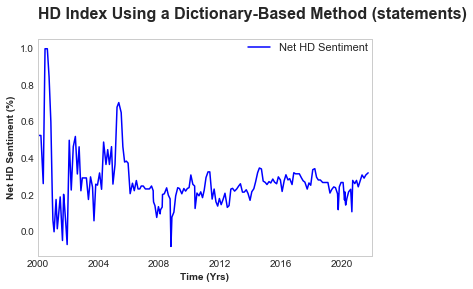

In [37]:
# HD-Index for statements

st_df.set_index('date', inplace=True, drop=True)
NetSentiment = st_df['Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Dictionary-Based Method ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(st_df.index, NetSentiment, c = 'blue', label = 'Net HD Sentiment')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(st_df.index[0], 'Y')
datemax = np.datetime64(st_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

# Save Graphics
fig.savefig(graph_dir + 'sentiment_bow_' + doc_type + '.png')

### Net Sentiments (Minutes)

In [38]:
doc_type = "minutes"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
# font_size_labels = 12 #@param {type:"raw"}
# font_size_xtick = 10 #@param {type:"raw"}
# font_size_ytick = 10 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''

title_loc = 'left'

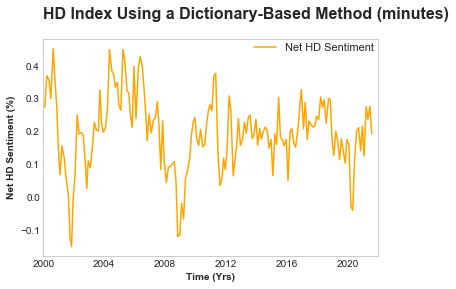

In [39]:
# HD-Index for Minutes

mins_df.set_index('date', inplace=True, drop=True)
NetSentiment = mins_df['Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Dictionary-Based Method ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(mins_df.index, NetSentiment, c = 'orange', label = 'Net HD Sentiment')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(mins_df.index[0], 'Y')
datemax = np.datetime64(mins_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

# Save Graphics
fig.savefig(graph_dir + 'sentiment_bow_' + doc_type + '.png')

### Combined Plot
Statements + Minutes

In [18]:
doc_type = "minutes"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
# font_size_labels = 12 #@param {type:"raw"}
# font_size_xtick = 10 #@param {type:"raw"}
# font_size_ytick = 10 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''

title_loc = 'left'

In [20]:
mins_df

,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB,Score
date,,,,,,,,,,,
2000-02-02,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[a buy sell us government securities including...,[meeting federal open market committee held of...,[a buy sell u government security include secu...,[meeting federal open market committee held of...,0.274914
2000-03-21,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[pending completion study committees considera...,[meeting federal open market committee held of...,[pending completion study committee considerat...,[meeting federal open market committee held of...,0.370588
2000-05-16,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic financia...,[meeting federal open market committee held of...,[committee turn discussion economic financial ...,[meeting federal open market committee held of...,0.356250
2000-06-28,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...,0.300613
2000-08-22,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[a meeting of the federal open market committe...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...,0.452830
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...,0.125673
2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a carlson senior economic project manage...,[federal reserve central bank united state pro...,0.276596
2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark a carlson senior economic project manage...,[federal reserve central bank united states pr...,[mark a c

ValueError: x and y must have same first dimension, but have shapes (188,) and (179,)

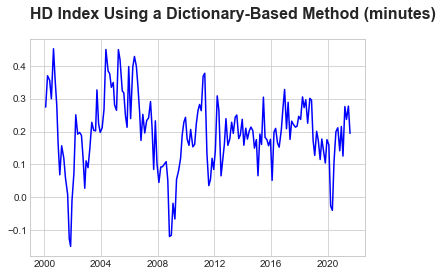

In [21]:
# HD-Index for Minutes

MinsNetSentiment = mins_df['Score']
StNetSentiment = st_df['Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Dictionary-Based Method ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(mins_df.index, MinsNetSentiment, c = 'blue', label = 'Net HD Sentiment (Minutes)')
ax.plot(st_df.index, MinsNetSentiment, c = 'orange', label = 'Net HD Sentiment (Statements)')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(mins_df.index[0], 'Y')
datemax = np.datetime64(mins_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

# Save Graphics
fig.savefig(graph_dir + 'sentiment_bow_' + doc_type + '.png')